In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import gc
gc.collect()

0

# ETL - taxis

## Carga de archivos

In [4]:
taxis_org = pd.read_parquet('../EDA/taxis.parquet')
#taxis_org = pd.read_parquet('/content/drive/MyDrive/Extras - Proyecto Final Henry/taxis.parquet')

In [5]:
taxis = taxis_org.copy()

In [6]:
taxis

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,ehail_fee,trip_type
0,1,2023-09-01 00:15:37,2023-09-01 00:20:21,1.0,0.80,1.0,N,163,230,2.0,...,0.5,0.00,0.0,1.0,11.50,2.5,0.00,yellow,NaN,NaN
1,2,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,2.34,1.0,N,236,233,1.0,...,0.5,2.00,0.0,1.0,21.20,2.5,0.00,yellow,NaN,NaN
2,2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,1.62,1.0,N,162,236,1.0,...,0.5,2.00,0.0,1.0,15.60,2.5,0.00,yellow,NaN,NaN
3,2,2023-09-01 00:45:45,2023-09-01 00:47:37,1.0,0.74,1.0,N,141,229,1.0,...,0.5,1.00,0.0,1.0,11.10,2.5,0.00,yellow,NaN,NaN
4,2,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,9.85,1.0,N,138,230,1.0,...,0.5,17.02,0.0,1.0,73.77,2.5,1.75,yellow,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40176766,2,2024-08-31 20:58:00,2024-08-31 21:25:00,NaN,13.50,NaN,None,223,132,NaN,...,0.0,10.03,0.0,1.0,60.67,NaN,NaN,green,NaN,NaN
40176767,2,2024-08-31 21:39:00,2024-08-31 21:56:00,NaN,1.78,NaN,None,129,7,NaN,...,0.0,3.00,0.0,1.0,21.86,NaN,NaN,green,NaN,NaN
40176768,2,2024-08-31 22:59:00,2024-08-31 23:19:00,NaN,3.27,NaN,None,255,65,NaN,...,0.0,4.89,0.0,1.0,29.84,NaN,NaN,green,NaN,NaN
40176769,2,2024-08-31 22:26:00,2024-08-31 22:42:00,NaN,2.50,NaN,None,244,41,NaN,...,0.0,0.00,0.0,1.0,21.09,NaN,NaN,green,NaN,NaN


In [ ]:
taxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40176771 entries, 0 to 40176770
Data columns (total 22 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee         

## Manejo de duplicados

Se encontraron 4 registros duplicados en todos los campos del dataframe.

In [ ]:
taxis[taxis.duplicated()]

In [6]:
taxis.drop(taxis[taxis.duplicated()].index, inplace=True)

## Manejo de nulos y vacios

Al realizar el análisis de valores nulos en el dataframe se obtuvó que existe en total 96.178.938 valores nulos entre todas las filas y columnas, distribuidos en las siguientes columnas:
- __*passenger_count*, *RatecodeID*, *store_and_fwd_flag*, *congestion_surcharge*:__ 3.157.799 registros con valores nulos en estos 4 campos a la vez.
- __*payment_type*:__ 36.326 registros con este campo en nulo.
- __*Airport_fee*:__ 3.824.776 registros con valor nulo que corresponden a los mismos 3.157.799 registros mencionados en el primer item y viajes en taxi de *type* 'green' que no contenian esta columna originalmente.
- __*ehail_fee*:__ Todos los valores son nulos. Adicionalmente, se encontró que esta columna no existe en los diccionarios de datos correspondientes a estos datasets.
- __*trip_type*:__ Todos los registros de viajese+ en taxi de *type* yellow que no contenian esta columna.

In [ ]:
taxis.isnull().sum().sum()

np.int64(96178938)

In [ ]:
taxis.isnull().sum()

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count           3157799
trip_distance                   0
RatecodeID                3157799
store_and_fwd_flag        3157799
PULocationID                    0
DOLocationID                    0
payment_type                36326
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
congestion_surcharge      3157799
Airport_fee               3824776
type                            0
ehail_fee                40176771
trip_type                39509869
dtype: int64

In [ ]:
taxis[(taxis['passenger_count'].isnull())
      &(taxis['RatecodeID'].isnull())
      &(taxis['store_and_fwd_flag'].isnull())
      &(taxis['congestion_surcharge'].isnull())
      &(taxis['Airport_fee'].isnull())]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,ehail_fee,trip_type
2706497,1,2023-09-01 00:40:49,2023-09-01 00:46:57,NaN,1.20,NaN,None,249,164,0.0,...,0.5,1.94,0.0,1.0,14.84,NaN,NaN,yellow,NaN,NaN
2706498,2,2023-09-01 00:11:15,2023-09-01 00:51:28,NaN,8.48,NaN,None,125,188,0.0,...,0.5,0.00,0.0,1.0,32.59,NaN,NaN,yellow,NaN,NaN
2706499,1,2023-09-01 00:02:50,2023-09-01 00:20:12,NaN,0.00,NaN,None,255,79,0.0,...,0.5,0.00,0.0,1.0,23.09,NaN,NaN,yellow,NaN,NaN
2706500,1,2023-09-01 00:09:54,2023-09-01 00:20:11,NaN,2.10,NaN,None,263,142,0.0,...,0.5,0.82,0.0,1.0,17.22,NaN,NaN,yellow,NaN,NaN
2706501,2,2023-09-01 00:15:58,2023-09-01 00:32:10,NaN,3.12,NaN,None,146,48,0.0,...,0.5,3.23,0.0,1.0,24.76,NaN,NaN,yellow,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40176766,2,2024-08-31 20:58:00,2024-08-31 21:25:00,NaN,13.50,NaN,None,223,132,NaN,...,0.0,10.03,0.0,1.0,60.67,NaN,NaN,green,NaN,NaN
40176767,2,2024-08-31 21:39:00,2024-08-31 21:56:00,NaN,1.78,NaN,None,129,7,NaN,...,0.0,3.00,0.0,1.0,21.86,NaN,NaN,green,NaN,NaN
40176768,2,2024-08-31 22:59:00,2024-08-31 23:19:00,NaN,3.27,NaN,None,255,65,NaN,...,0.0,4.89,0.0,1.0,29.84,NaN,NaN,green,NaN,NaN
40176769,2,2024-08-31 22:26:00,2024-08-31 22:42:00,NaN,2.50,NaN,None,244,41,NaN,...,0.0,0.00,0.0,1.0,21.09,NaN,NaN,green,NaN,NaN


### Eliminados

- *ehail_fee* es una columna que solo tiene nulos y no esta definida en los diccionarios. 
- *VendorID* hace referencia a la entidad que aporto el registro por lo tanto no contien einformacion del viaje

In [7]:
taxis.drop(columns=['ehail_fee','VendorID'], inplace=True)

### Reemplazados

In [8]:
taxis['passenger_count'] = taxis['passenger_count'].fillna(taxis['passenger_count'].mean()).astype(int)

In [9]:
mod = taxis['RatecodeID'].mode().iloc[0]
taxis['RatecodeID'] = taxis['RatecodeID'].fillna(mod)

In [10]:
mod = taxis['store_and_fwd_flag'].mode().iloc[0]
taxis['store_and_fwd_flag'] = taxis['store_and_fwd_flag'].fillna(mod)

In [11]:
mod = taxis['payment_type'].mode().iloc[0]
taxis['payment_type'] = taxis['payment_type'].fillna(mod)

In [12]:
mod = taxis['trip_type'].mode().iloc[0]
taxis['trip_type'] = taxis['trip_type'].fillna(mod)

In [13]:
mod = taxis['congestion_surcharge'].mode().iloc[0]
taxis['congestion_surcharge'] = taxis['congestion_surcharge'].fillna(mod)

In [14]:
mod = taxis['Airport_fee'].mode().iloc[0]
taxis['Airport_fee'] = taxis['Airport_fee'].fillna(mod)

In [76]:
taxis.isnull().sum()

,0
VendorID,0
tpep_pickup_datetime,0
tpep_dropoff_datetime,0
passenger_count,0
trip_distance,0
RatecodeID,0
store_and_fwd_flag,0
PULocationID,0
DOLocationID,0
payment_type,0


In [15]:
mod = taxis['RatecodeID'].mode().iloc[0]
taxis['RatecodeID'] = taxis['RatecodeID'].apply(lambda x : mod if x == 99 else x)

In [3]:
taxis['passenger_count'] = taxis['passenger_count'].apply(lambda x : 1 if x == 0 else x)

In [ ]:
taxis['payment_type'] = taxis['payment_type'].apply(lambda x : x + 1)

51 registros fuera del rango de tiempo

In [19]:
taxis.drop(taxis[~((taxis['tpep_dropoff_datetime'].dt.year==2023)|(taxis['tpep_dropoff_datetime'].dt.year==2024)|(taxis['tpep_pickup_datetime'].dt.year==2023)|(taxis['tpep_pickup_datetime'].dt.year==2024))].index, inplace=True)

1497 registros que el pickup es despues del dropoff

In [80]:
taxis[taxis['tpep_dropoff_datetime']<taxis['tpep_pickup_datetime']]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,trip_type
492572,1,2023-09-06 18:15:00,2023-09-06 15:38:03,1,11.3,1.0,N,145,210,2,...,0.0,0.5,0.0,0.0,1.0,16.0,0.0,0.0,yellow,1.0
556953,1,2023-09-07 11:29:00,2023-09-07 11:06:12,1,2.6,1.0,N,203,205,2,...,0.0,0.5,0.0,0.0,1.0,23.0,0.0,0.0,yellow,1.0
998898,1,2023-09-11 10:17:05,2023-09-11 00:00:00,1,0.0,1.0,N,161,50,2,...,0.0,0.0,0.0,0.0,0.0,18.9,0.0,0.0,yellow,1.0
1227723,1,2023-09-13 11:56:00,2023-09-13 11:28:06,1,7.9,1.0,N,218,39,2,...,0.0,0.5,0.0,0.0,1.0,35.0,0.0,0.0,yellow,1.0
1368789,1,2023-09-14 15:46:00,2023-09-14 13:00:57,1,3.5,1.0,N,3,213,2,...,0.0,0.5,0.0,0.0,1.0,29.0,0.0,0.0,yellow,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38279110,1,2024-08-21 09:00:00,2024-08-21 08:46:40,1,6.8,1.0,N,39,205,2,...,0.0,0.5,0.0,0.0,0.0,34.0,0.0,0.0,yellow,1.0
38680336,1,2024-08-25 20:00:00,2024-08-25 19:21:24,1,1.6,1.0,N,61,49,2,...,0.0,0.5,0.0,0.0,0.0,20.0,0.0,0.0,yellow,1.0
38907633,1,2024-08-28 15:27:00,2024-08-28 15:26:39,1,1.0,1.0,N,35,177,2,...,0.0,0.5,0.0,0.0,0.0,18.0,0.0,0.0,yellow,1.0
38978174,1,2024-08-29 11:30:00,2024-08-29 11:10:31,1,0.0,1.0,N,76,76,2,...,0.0,0.5,0.0,0.0,1.0,52.0,0.0,0.0,yellow,1.0


In [20]:
taxis['pickup_datetime'] = np.minimum(taxis['tpep_dropoff_datetime'], taxis['tpep_pickup_datetime'])

In [21]:
taxis['dropoff_datetime'] = np.maximum(taxis['tpep_dropoff_datetime'], taxis['tpep_pickup_datetime'])

In [22]:
taxis[taxis['dropoff_datetime']<taxis['pickup_datetime']]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,trip_type,pickup_datetime,dropoff_datetime


In [23]:
taxis.drop(columns=['tpep_pickup_datetime','tpep_dropoff_datetime'], inplace=True)
taxis

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,trip_type,pickup_datetime,dropoff_datetime
0,1,0.80,1.0,N,163,230,3,6.50,3.5,0.5,0.00,0.0,1.0,11.50,2.5,0.00,yellow,1.0,2023-09-01 00:15:37,2023-09-01 00:20:21
1,2,2.34,1.0,N,236,233,2,14.20,1.0,0.5,2.00,0.0,1.0,21.20,2.5,0.00,yellow,1.0,2023-09-01 00:18:40,2023-09-01 00:30:28
2,1,1.62,1.0,N,162,236,2,8.60,1.0,0.5,2.00,0.0,1.0,15.60,2.5,0.00,yellow,1.0,2023-09-01 00:35:01,2023-09-01 00:39:04
3,1,0.74,1.0,N,141,229,2,5.10,1.0,0.5,1.00,0.0,1.0,11.10,2.5,0.00,yellow,1.0,2023-09-01 00:45:45,2023-09-01 00:47:37
4,1,9.85,1.0,N,138,230,2,45.00,6.0,0.5,17.02,0.0,1.0,73.77,2.5,1.75,yellow,1.0,2023-09-01 00:01:23,2023-09-01 00:38:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40176766,1,13.50,1.0,N,223,132,2,49.64,0.0,0.0,10.03,0.0,1.0,60.67,2.5,0.00,green,1.0,2024-08-31 20:58:00,2024-08-31 21:25:00
40176767,1,1.78,1.0,N,129,7,2,17.86,0.0,0.0,3.00,0.0,1.0,21.86,2.5,0.00,green,1.0,2024-08-31 21:39:00,2024-08-31 21:56:00
40176768,1,3.27,1.0,N,255,65,2,23.95,0.0,0.0,4.89,0.0,1.0,29.84,2.5,0.00,green,1.0,2024-08-31 22:59:00,2024-08-31 23:19:00
40176769,1,2.50,1.0,N,244,41,2,20.09,0.0,0.0,0.00,0.0,1.0,21.09,2.5,0.00,green,1.0,2024-08-31 22:26:00,2024-08-31 22:42:00


In [24]:
taxis['duration'] = taxis['dropoff_datetime'] - taxis['pickup_datetime']
taxis['duration'] = taxis['duration'].dt.total_seconds() / 60

In [35]:
taxis[taxis['duration']<0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,trip_type,duration,pickup_datetime,dropoff_datetime


In [38]:
taxis.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_type,duration,pickup_datetime,dropoff_datetime
count,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,40176720,40176720
mean,1.757901e+00,1.321533e+00,4.730957e+00,1.078465e+00,1.634134e+02,1.632935e+02,2.132964e+00,1.935047e+01,1.428466e+00,4.836007e-01,3.361928e+00,5.705839e-01,9.705301e-01,2.800863e+01,2.241276e+00,1.357026e-01,1.000707e+00,1.816679e+01,2024-03-02 08:40:44.025908,2024-03-02 08:58:54.033327
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-2.261200e+03,-3.917000e+01,-5.000000e-01,-3.308800e+02,-1.172600e+02,-1.000000e+00,-2.265450e+03,-2.750000e+00,-1.750000e+00,1.000000e+00,0.000000e+00,1970-01-20 10:16:32,2023-08-25 19:55:46
25%,2.000000e+00,1.000000e+00,1.010000e+00,1.000000e+00,1.320000e+02,1.130000e+02,2.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.575000e+01,2.500000e+00,0.000000e+00,1.000000e+00,7.750000e+00,2023-12-02 01:22:17.750000,2023-12-02 01:36:10.750000
50%,2.000000e+00,1.000000e+00,1.750000e+00,1.000000e+00,1.610000e+02,1.620000e+02,2.000000e+00,1.350000e+01,1.000000e+00,5.000000e-01,2.660000e+00,0.000000e+00,1.000000e+00,2.100000e+01,2.500000e+00,0.000000e+00,1.000000e+00,1.285000e+01,2024-03-06 20:13:36,2024-03-06 20:28:27.500000
75%,2.000000e+00,1.000000e+00,3.340000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,2.258000e+01,2.500000e+00,5.000000e-01,4.280000e+00,0.000000e+00,1.000000e+00,3.060000e+01,2.500000e+00,0.000000e+00,1.000000e+00,2.091667e+01,2024-05-29 18:20:22.250000,2024-05-29 18:39:16
max,6.000000e+00,9.000000e+00,3.270252e+05,6.000000e+00,2.650000e+02,2.650000e+02,6.000000e+00,3.340763e+05,1.000250e+04,5.209000e+01,4.174000e+03,1.702880e+03,1.000000e+00,3.341453e+05,2.750000e+00,1.750000e+00,2.000000e+00,2.824830e+07,2024-09-10 12:27:29,2024-09-10 19:45:57
std,4.303686e-01,8.238071e-01,3.430243e+02,4.290418e-01,6.468635e+01,6.980201e+01,6.191356e-01,6.791400e+01,2.411811e+00,1.316941e-01,4.138528e+00,2.235707e+00,2.316698e-01,6.948754e+01,8.428549e-01,4.806027e-01,2.658851e-02,4.456767e+03,NaN,NaN


583276 registros co negativos

In [25]:
taxis[(taxis['fare_amount']<0)|(taxis['extra']<0)|(taxis['mta_tax']<0)|(taxis['tip_amount']<0)|(taxis['tolls_amount']<0)|(taxis['improvement_surcharge']<0)|(taxis['total_amount']<0)]

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,trip_type,pickup_datetime,dropoff_datetime,duration
71,1,0.80,1.0,N,249,234,4,-5.80,-1.0,-0.5,...,0.0,-1.0,-10.80,-2.5,0.0,yellow,1.0,2023-09-01 00:28:17,2023-09-01 00:31:31,3.233333
310,1,0.86,1.0,N,68,48,5,-10.00,-1.0,-0.5,...,0.0,-1.0,-15.00,-2.5,0.0,yellow,1.0,2023-09-01 00:58:03,2023-09-01 01:07:59,9.933333
330,1,0.35,1.0,N,263,263,5,-3.70,-1.0,-0.5,...,0.0,-1.0,-8.70,-2.5,0.0,yellow,1.0,2023-09-01 00:49:21,2023-09-01 00:50:30,1.150000
347,2,3.80,1.0,N,238,116,5,-17.70,-1.0,-0.5,...,0.0,-1.0,-22.70,-2.5,0.0,yellow,1.0,2023-09-01 00:34:28,2023-09-01 00:47:47,13.316667
368,1,1.01,1.0,N,230,48,3,-8.60,-1.0,-0.5,...,0.0,-1.0,-13.60,-2.5,0.0,yellow,1.0,2023-09-01 00:00:54,2023-09-01 00:08:45,7.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40174305,1,0.09,1.0,N,166,166,4,-3.70,0.0,-0.5,...,0.0,-1.0,-5.20,0.0,0.0,green,1.0,2024-08-31 13:16:25,2024-08-31 13:17:24,0.983333
40175001,4,0.63,1.0,N,93,93,3,-5.80,-1.0,-0.5,...,0.0,-1.0,-8.30,0.0,0.0,green,1.0,2024-08-31 21:46:52,2024-08-31 21:50:15,3.383333
40175751,1,3.06,1.0,N,145,37,2,-1.31,0.0,0.0,...,0.0,1.0,1.69,2.5,0.0,green,1.0,2024-08-11 19:56:49,2024-08-11 20:15:44,18.916667
40175854,1,3.31,1.0,N,83,7,2,-0.50,0.0,0.0,...,0.0,1.0,0.50,2.5,0.0,green,1.0,2024-08-13 18:48:00,2024-08-13 19:06:00,18.000000


In [26]:
taxis['fare_amount'] = abs(taxis['fare_amount'])
taxis['extra'] = abs(taxis['extra'])
taxis['mta_tax'] = abs(taxis['mta_tax'])
taxis['tip_amount'] = abs(taxis['tip_amount'])
taxis['tolls_amount'] = abs(taxis['tolls_amount'])
taxis['total_amount'] = abs(taxis['total_amount'])
taxis['improvement_surcharge'] = abs(taxis['improvement_surcharge'])
taxis['congestion_surcharge'] = abs(taxis['congestion_surcharge'])
taxis['Airport_fee'] = abs(taxis['Airport_fee'])

In [27]:
taxis[(taxis['fare_amount']<0)|(taxis['extra']<0)|(taxis['mta_tax']<0)|(taxis['tip_amount']<0)|(taxis['tolls_amount']<0)|(taxis['improvement_surcharge']<0)|(taxis['total_amount']<0)]

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,type,trip_type,pickup_datetime,dropoff_datetime,duration


In [28]:
taxis.describe()

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_type,pickup_datetime,dropoff_datetime,duration
count,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,4.017672e+07,40176716,40176716,4.017672e+07
mean,1.321533e+00,4.730957e+00,1.078465e+00,1.634134e+02,1.632935e+02,2.132964e+00,1.990766e+01,1.453363e+00,4.957393e-01,3.362479e+00,5.863813e-01,9.956730e-01,2.869396e+01,2.292202e+00,1.425111e-01,1.000707e+00,2024-03-02 08:40:44.251851,2024-03-02 08:58:54.259140,1.816679e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1970-01-20 10:16:32,2023-08-25 19:55:46,0.000000e+00
25%,1.000000e+00,1.010000e+00,1.000000e+00,1.320000e+02,1.130000e+02,2.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.596000e+01,2.500000e+00,0.000000e+00,1.000000e+00,2023-12-02 01:22:18,2023-12-02 01:36:11,7.750000e+00
50%,1.000000e+00,1.750000e+00,1.000000e+00,1.610000e+02,1.620000e+02,2.000000e+00,1.382000e+01,1.000000e+00,5.000000e-01,2.660000e+00,0.000000e+00,1.000000e+00,2.100000e+01,2.500000e+00,0.000000e+00,1.000000e+00,2024-03-06 20:13:36,2024-03-06 20:28:28,1.285000e+01
75%,1.000000e+00,3.340000e+00,1.000000e+00,2.330000e+02,2.340000e+02,2.000000e+00,2.260000e+01,2.500000e+00,5.000000e-01,4.280000e+00,0.000000e+00,1.000000e+00,3.072000e+01,2.500000e+00,0.000000e+00,1.000000e+00,2024-05-29 18:20:22.250000,2024-05-29 18:39:16,2.091667e+01
max,9.000000e+00,3.270252e+05,6.000000e+00,2.650000e+02,2.650000e+02,6.000000e+00,3.340763e+05,1.000250e+04,5.209000e+01,4.174000e+03,1.702880e+03,1.000000e+00,3.341453e+05,2.750000e+00,1.750000e+00,2.000000e+00,2024-09-10 12:27:29,2024-09-10 19:45:57,2.824830e+07
std,8.238071e-01,3.430243e+02,4.290418e-01,6.468635e+01,6.980201e+01,6.191356e-01,6.775276e+01,2.396891e+00,7.386151e-02,4.138080e+00,2.231615e+00,6.507649e-02,6.920736e+01,6.924819e-01,4.786280e-01,2.658851e-02,NaN,NaN,4.456768e+03


In [3]:
taxis.shape[0]

40176716

## Outliers

Se realizó el análisis de Outliers para las variables cauntitativas. Teniendo en cuenta los graficos anteriores se decidio abordar este analisis de dos maneras diferentes. Para las variables con "valores definidos" (*passenger_count*, *improvement_surcharge*, *congestion_surcharge* y *Airport_fee*) se tomo como outlier aquellos valores para los cuales existiera un numero de registros menores al 1% del total. Para las demas variables (*fare_amount*, *tip_amount*, *tolls_amount*, *total_amount*, *extra*, *mta_tax* y *trip_distance*) se llevo a cabo un analisis de outliers haciendo uso de un grafico de BoxPlot. 

### Variables de valores definidos

Teniendo en cuenta el criterio del 1% mencionado anteriormente (401.767 registros minimo), se tendria que los siguientes serian los Outliers para estas variables.

| Variable | Valores Outliers | Cantidad de Outliers | Porcentaje de Outliers |
| -------- | ---------------- | -------------------- | ---------------------- |
| passenger_count | [6, 8, 7, 9] | 267174 | 0.66 % |
| improvement_surcharge | [0.0, 0.3] | 177869 | 0.44 % |
| congestion_surcharge | [2.75, 0.75, 2.52] | 181610 | 0.45 % |
| Airport_fee | [1.25] | 23 | 0.0 % |

#### Identificar Outliers

In [4]:
tot = taxis.shape[0]

In [5]:
def out_def (col):
    n = 0
    l = []
    for index, row in taxis[col].value_counts().to_frame().iterrows():
        if row['count'] < tot*0.01:
            n += row['count']
            l.append(index)
    print(f'| {col} | {l} | {n} | {round((n/tot)*100,2)} % |')
    return l

In [4]:
taxis['passenger_count'].value_counts()

passenger_count
1    31981087
2     5431220
3     1296345
4      793498
5      407392
6      266687
8         294
7         110
9          83
Name: count, dtype: int64

Improvement surcharge aumento de 0.3 a 1 en 2022

In [32]:
taxis['improvement_surcharge'].value_counts()

improvement_surcharge
1.0    39998658
0.0      164020
0.3       14038
Name: count, dtype: int64

E·congestion surcharge en NYC para taxis es 2.5

In [33]:
taxis['congestion_surcharge'].value_counts()

congestion_surcharge
2.50    36630424
0.00     3358240
2.75      188028
0.75          12
1.00           9
0.50           1
2.00           1
2.52           1
Name: count, dtype: int64

In [34]:
taxis['Airport_fee'].value_counts()

Airport_fee
0.00    36904921
1.75     3271772
1.25          23
Name: count, dtype: int64

#### Eliminar Outliers

In [6]:
print('| Variable | Valores Outliers | Cantidad de Outliers | Porcentaje de Outliers |')
print('| -------- | ---------------- | -------------------- | ---------------------- |')
for i in ['passenger_count','improvement_surcharge','congestion_surcharge','Airport_fee']:
    l = out_def(i)
    taxis.drop(taxis[taxis[i].isin(l)].index, inplace=True)

| Variable | Valores Outliers | Cantidad de Outliers | Porcentaje de Outliers |
| -------- | ---------------- | -------------------- | ---------------------- |
| passenger_count | [6, 8, 7, 9] | 267174 | 0.66 % |
| improvement_surcharge | [0.0, 0.3] | 177869 | 0.44 % |
| congestion_surcharge | [2.75, 0.75, 2.52] | 181610 | 0.45 % |
| Airport_fee | [1.25] | 23 | 0.0 % |


### Boxplots

In [ ]:
var_cuanti = taxis[['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_distance','duration']]

#### Identificar Outliers

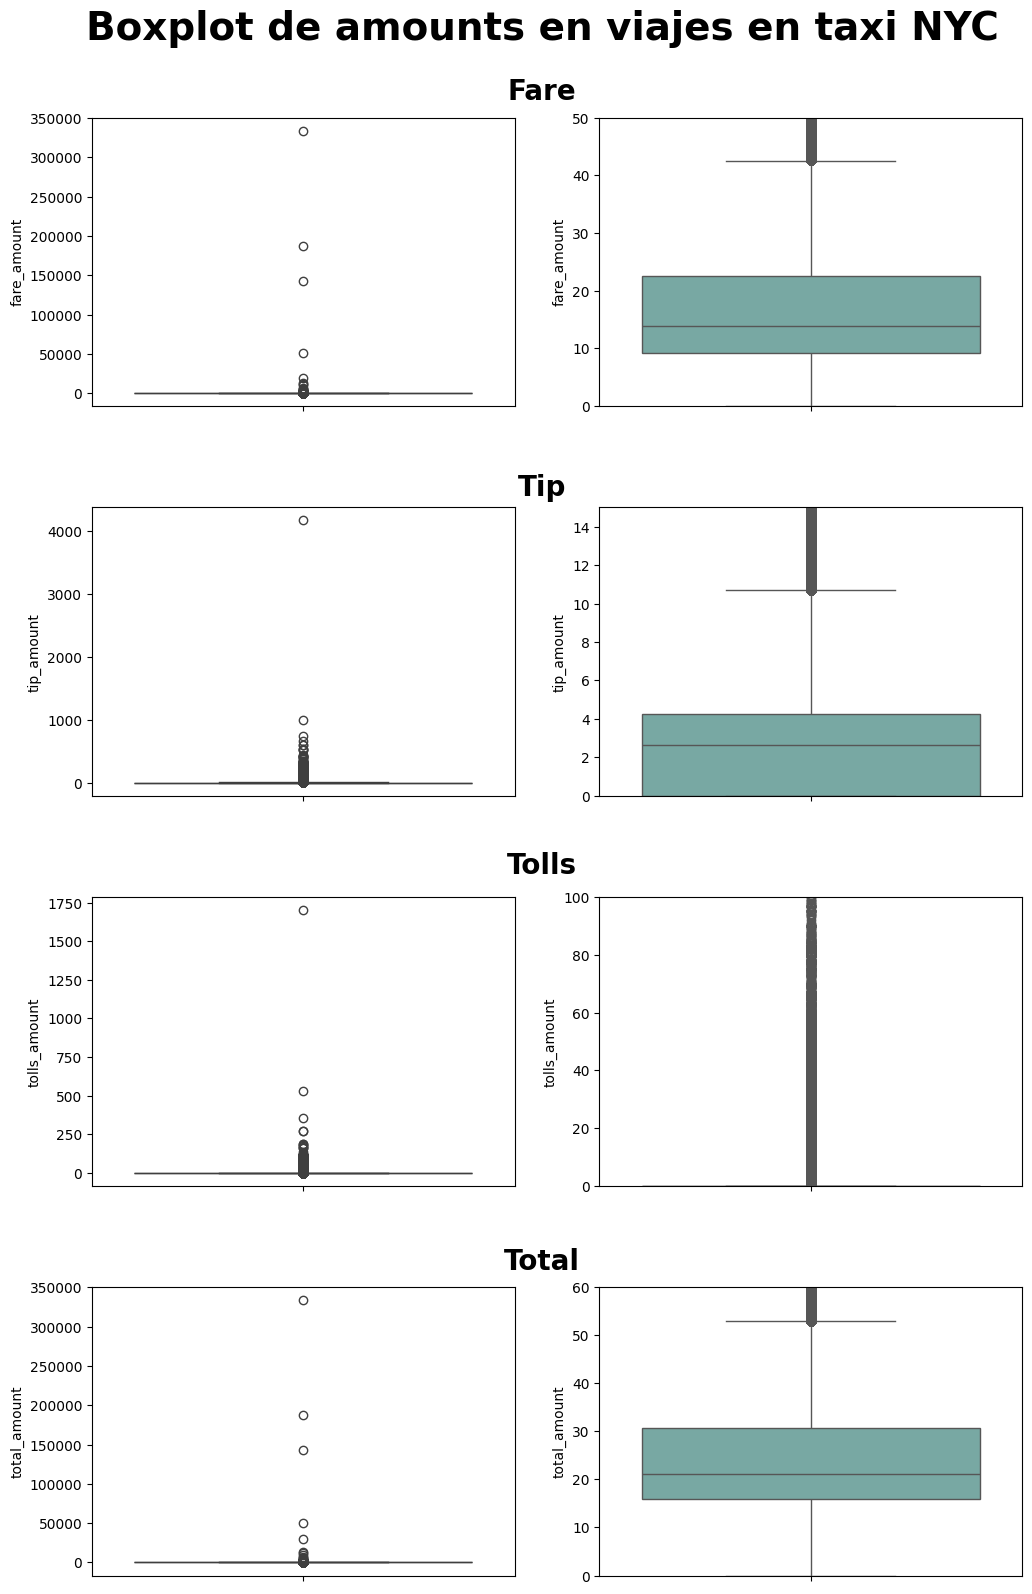

In [56]:
fig, ax = plt.subplots(4, 2, figsize=(12, 18))
fig.suptitle('Boxplot de amounts en viajes en taxi NYC', fontsize=28, fontweight='bold')
plt.subplots_adjust(top = 0.92, hspace=0.35)

fig.text(0.5, 0.93, 'Fare', ha='center', fontsize=20, fontweight='bold')
fig.text(0.5, 0.71, 'Tip', ha='center', fontsize=20, fontweight='bold')
fig.text(0.5, 0.50, 'Tolls', ha='center', fontsize=20, fontweight='bold')
fig.text(0.5, 0.28, 'Total', ha='center', fontsize=20, fontweight='bold')


sns.boxplot(data=var_cuanti, y='fare_amount', ax = ax[0,0])
sns.boxplot(data=var_cuanti, y='fare_amount', saturation=0.3, color='turquoise', ax = ax[0,1])
ax[0,1].set_ylim(0, 50)

sns.boxplot(data=var_cuanti, y='tip_amount', ax = ax[1,0])
sns.boxplot(data=var_cuanti, y='tip_amount', saturation=0.3, color='turquoise', ax = ax[1,1])
ax[1,1].set_ylim(0, 15)

sns.boxplot(data=var_cuanti, y='tolls_amount', ax = ax[2,0])
sns.boxplot(data=var_cuanti, y='tolls_amount', saturation=0.3, color='turquoise', ax = ax[2,1])
ax[2,1].set_ylim(0, 100)

sns.boxplot(data=var_cuanti, y='total_amount', ax = ax[3,0])
sns.boxplot(data=var_cuanti, y='total_amount', saturation=0.3, color='turquoise', ax = ax[3,1])
ax[3,1].set_ylim(0, 60)

plt.show()

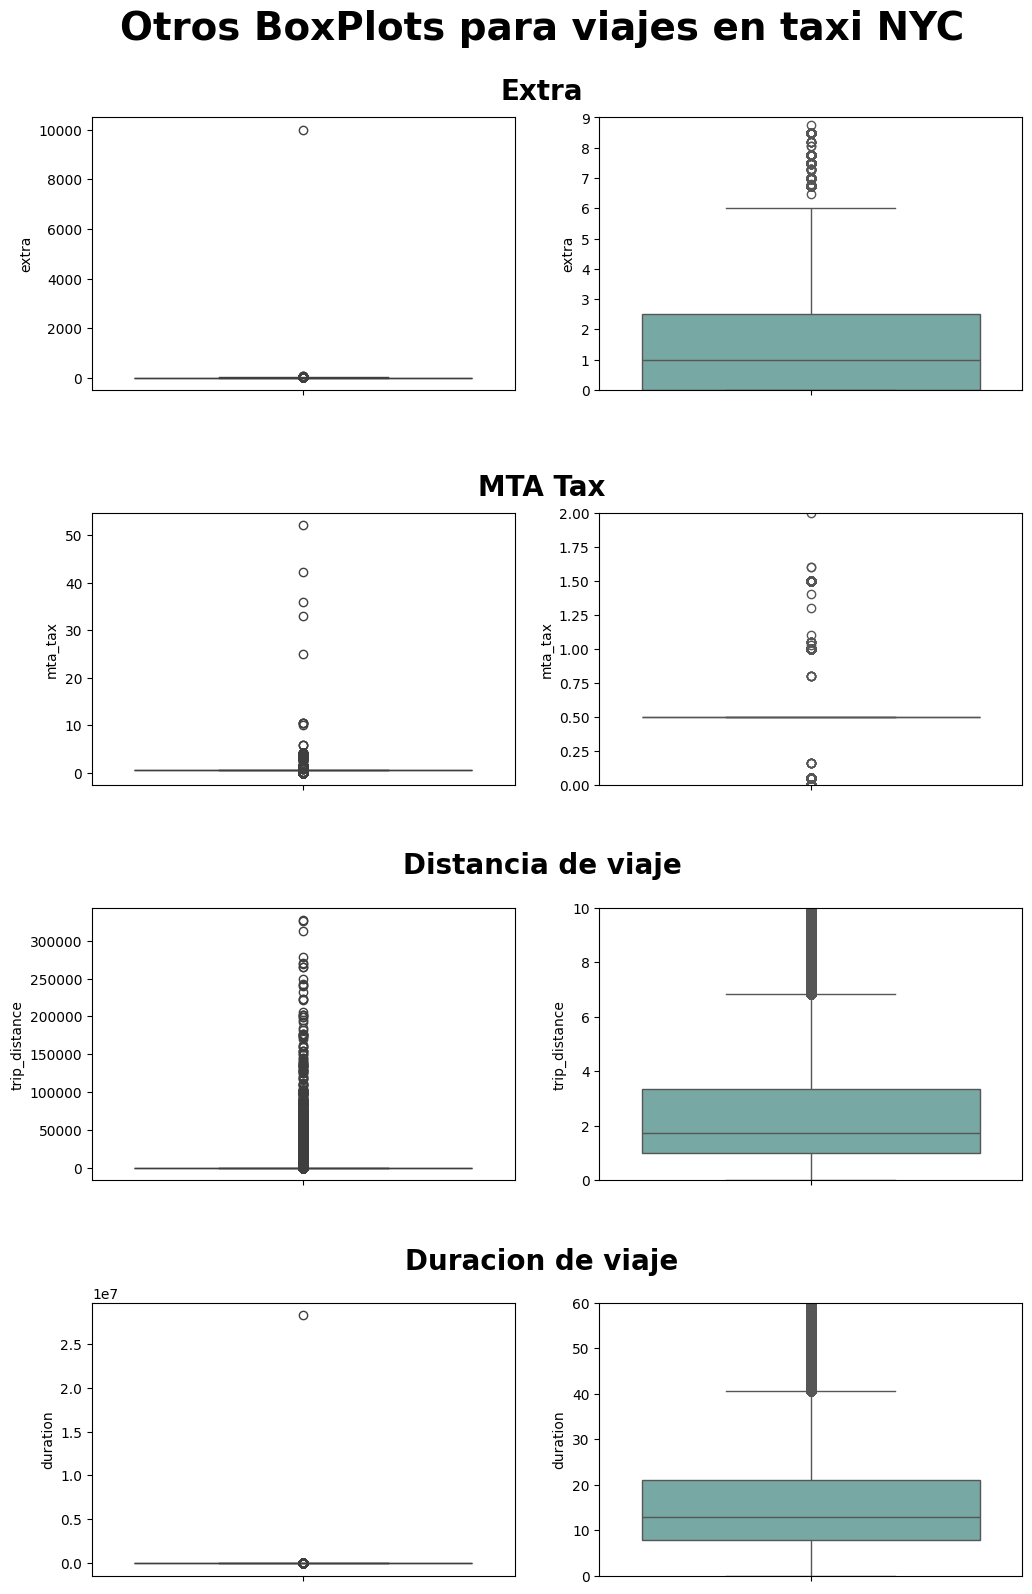

In [57]:
fig, ax = plt.subplots(4, 2, figsize=(12, 18))
fig.suptitle('Otros BoxPlots para viajes en taxi NYC', fontsize=28, fontweight='bold')
plt.subplots_adjust(top = 0.92, hspace=0.45)

fig.text(0.5, 0.93, 'Extra', ha='center', fontsize=20, fontweight='bold')
fig.text(0.5, 0.71, 'MTA Tax', ha='center', fontsize=20, fontweight='bold')
fig.text(0.5, 0.50, 'Distancia de viaje', ha='center', fontsize=20, fontweight='bold')
fig.text(0.5, 0.28, 'Duracion de viaje', ha='center', fontsize=20, fontweight='bold')

sns.boxplot(data=var_cuanti, y='extra', ax = ax[0,0])
sns.boxplot(data=var_cuanti, y='extra', saturation=0.3, color='turquoise', ax = ax[0,1])
ax[0,1].set_ylim(0, 9)

sns.boxplot(data=var_cuanti, y='mta_tax', ax = ax[1,0])
sns.boxplot(data=var_cuanti, y='mta_tax', saturation=0.3, color='turquoise', ax = ax[1,1])
ax[1,1].set_ylim(0, 2)

sns.boxplot(data=var_cuanti, y='trip_distance', ax = ax[2,0])
sns.boxplot(data=var_cuanti, y='trip_distance', saturation=0.3, color='turquoise', ax = ax[2,1])
ax[2,1].set_ylim(0,10)

sns.boxplot(data=var_cuanti, y='duration', ax = ax[3,0])
sns.boxplot(data=var_cuanti, y='duration', saturation=0.3, color='turquoise', ax=ax[3,1])
ax[3,1].set_ylim(0, 60)

plt.show()

In [7]:
def outliers (col):
    '''
    Funcion que imprime los valores minimo, maximo, cantidad de outliers y su porcentaje en formato de tabla
        Parametros:
            col (str): Nombre de la columna
    '''
    Q3 = float(taxis[col].quantile(0.75))
    Q1 = float(taxis[col].quantile(0.25))
    RIC = Q3 - Q1

    Min = Q1 - 1.5*RIC
    Max = Q3 + 1.5*RIC

    out = taxis[(taxis[col]<Min)|(taxis[col]>Max)]
    m = taxis[col].mean()
    c = out.shape[0] 
    p = (c/tot)*100

    print(f'| {col} | {round(m,2)} | {round(Min,2)} | {round(Max,2)} | {round(c,2)} | {round(p,2)} % |')


    return Max

| Variable | Promedio | Minimo | Maximo | Cantidad de Outliers | Porcentaje de Outliers |
| -------- | -------- | ------ | ------ | -------------------- | ---------------------- |
| fare_amount | 19.85 | -10.65 | 42.55 | 3768766 | 9.38 % |
| extra | 1.46 | -3.75 | 6.25 | 671299 | 1.67 % |
| mta_tax | 0.5 | 0.5 | 0.5 | 548871 | 1.37 % |
| tip_amount | 3.37 | -6.42 | 10.7 | 2317620 | 5.77 % |
| tolls_amount | 0.59 | 0.0 | 0.0 | 3045175 | 7.58 % |
| total_amount | 28.66 | -6.18 | 52.83 | 4414796 | 10.99 % |
| trip_distance | 4.66 | -2.44 | 6.76 | 5073815 | 12.63 % |
| duration | 18.01 | -11.89 | 40.44 | 2334723 | 5.81 % |

#### Eliminar Outliers

In [8]:
print('| Variable | Promedio | Minimo | Maximo | Cantidad de Outliers | Porcentaje de Outliers |')
print('| -------- | -------- | ------ | ------ | -------------------- | ---------------------- |')

for i in ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_distance','duration']:

  m = outliers(i)
  taxis.drop(taxis[taxis[i]>m].index, inplace=True)

| Variable | Promedio | Minimo | Maximo | Cantidad de Outliers | Porcentaje de Outliers |
| -------- | -------- | ------ | ------ | -------------------- | ---------------------- |
| fare_amount | 19.85 | -10.65 | 42.55 | 3768766 | 9.38 % |
| extra | 1.36 | -3.75 | 6.25 | 301019 | 0.75 % |
| mta_tax | 0.5 | 0.5 | 0.5 | 211620 | 0.53 % |
| tip_amount | 2.65 | -5.88 | 9.8 | 466323 | 1.16 % |
| tolls_amount | 0.07 | 0.0 | 0.0 | 360805 | 0.9 % |
| total_amount | 21.54 | -0.81 | 42.15 | 1071616 | 2.67 % |
| trip_distance | 3.1 | -1.27 | 4.62 | 1779873 | 4.43 % |
| duration | 13.8 | -6.71 | 29.62 | 736091 | 1.83 % |


In [9]:
taxis.shape[0]

31007804

In [11]:
taxis.to_parquet('taxis_def.parquet')

In [17]:
pd.options.display.float_format = '{:.2f}'.format
taxis.describe().iloc[1:,:]

,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,trip_type,pickup_datetime,dropoff_datetime,duration
mean,1.29,1.63,1.01,168.11,166.89,2.13,12.62,1.26,0.50,2.34,0.00,1.00,19.58,2.40,0.01,1.00,2024-03-02 11:22:12.715712,2024-03-02 11:33:50.528708,11.63
min,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,2023-08-25 21:08:34,2023-08-25 21:17:57,0.00
25%,1.00,0.90,1.00,132.00,116.00,2.00,8.60,0.00,0.50,0.00,0.00,1.00,14.88,2.50,0.00,1.00,2023-12-03 10:20:57.500000,2023-12-03 10:30:19,6.83
50%,1.00,1.42,1.00,163.00,163.00,2.00,11.70,1.00,0.50,2.46,0.00,1.00,18.72,2.50,0.00,1.00,2024-03-06 15:51:44.500000,2024-03-06 16:04:26,10.62
75%,1.00,2.18,1.00,234.00,234.00,2.00,16.30,2.50,0.50,3.60,0.00,1.00,23.60,2.50,0.00,1.00,2024-05-28 20:41:20,2024-05-28 20:51:54,15.55
max,5.00,4.61,6.00,265.00,265.00,5.00,42.48,6.00,0.50,9.80,0.00,1.00,42.15,2.50,1.75,2.00,2024-09-10 12:11:42,2024-09-10 12:15:25,29.62
std,0.71,0.98,0.21,65.38,67.89,0.61,5.41,1.43,0.03,1.82,0.00,0.00,6.39,0.49,0.13,0.02,NaN,NaN,6.23


### Histogramas

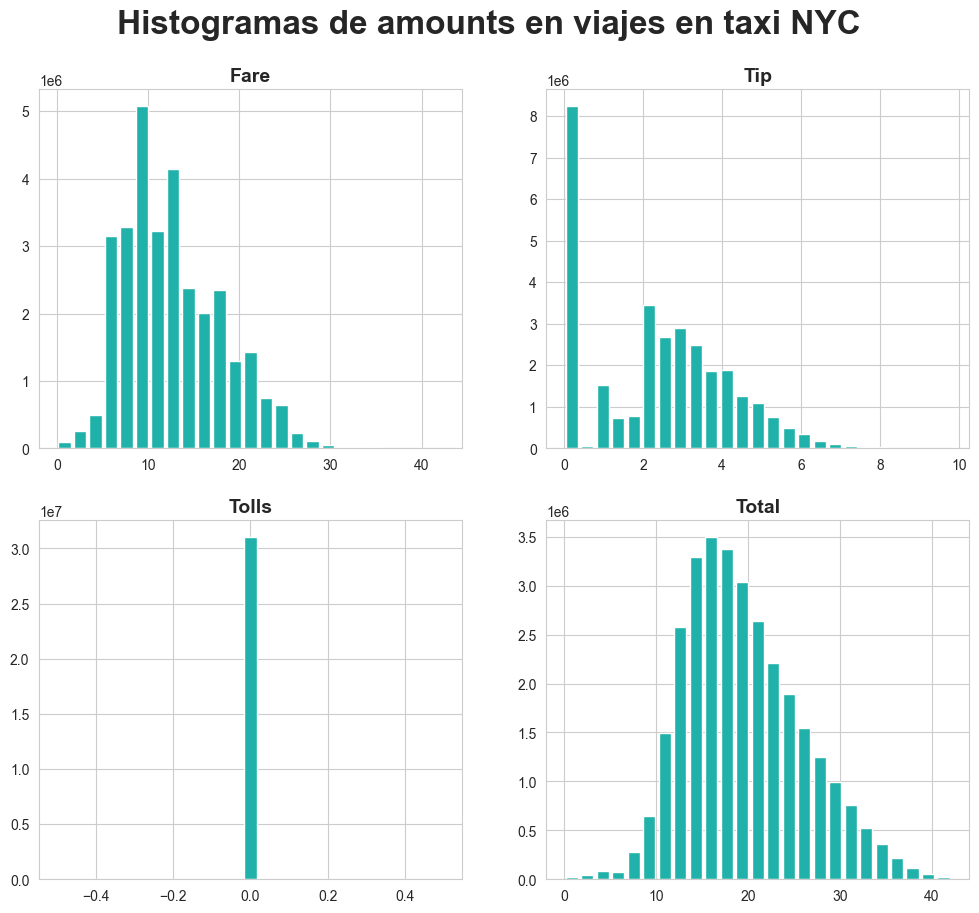

In [12]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2,2, figsize = (12,10), gridspec_kw={'height_ratios': [1, 1]})
fig.suptitle("Histogramas de amounts en viajes en taxi NYC",fontsize=24, fontweight='bold')
plt.subplots_adjust(top=0.9,hspace=0.2)

ax[0,0].hist(taxis['fare_amount'], bins=25, rwidth=0.8, color='lightseagreen')
ax[0,0].set_title('Fare',fontsize=14, fontweight='bold')

ax[0,1].hist(taxis['tip_amount'], bins=25, rwidth=0.8, color='lightseagreen')
ax[0,1].set_title('Tip',fontsize=14, fontweight='bold')

ax[1,0].hist(taxis['tolls_amount'], bins=25, rwidth=0.8, color='lightseagreen')
ax[1,0].set_title('Tolls',fontsize=14, fontweight='bold')

ax[1,1].hist(taxis['total_amount'], bins=25, rwidth=0.8, color='lightseagreen')
ax[1,1].set_title('Total',fontsize=14, fontweight='bold')

plt.show()

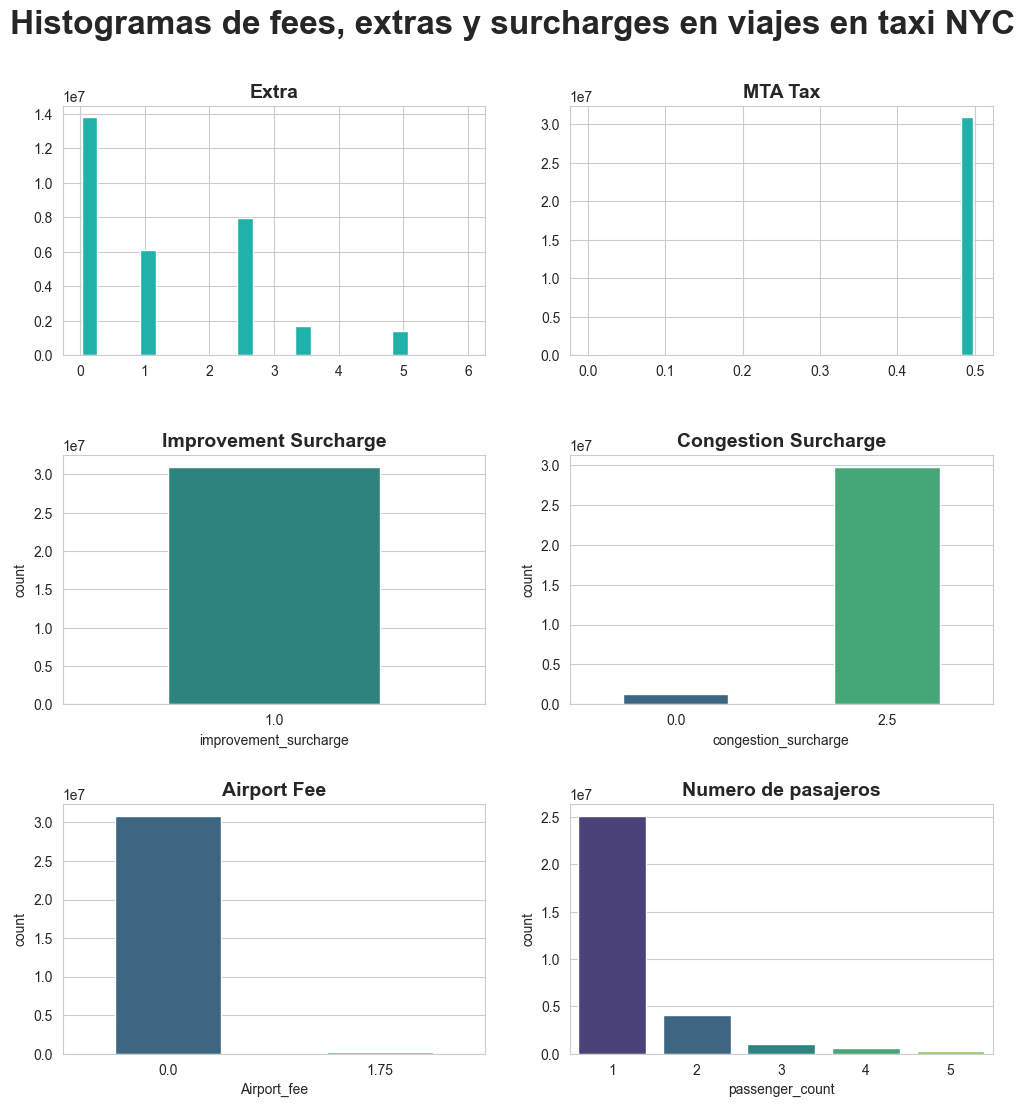

In [15]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(3,2, figsize = (12,12))
fig.suptitle("Histogramas de fees, extras y surcharges en viajes en taxi NYC",fontsize=24, fontweight='bold')
plt.subplots_adjust(top=0.9,hspace=0.4)

ax[0,0].hist(taxis['extra'], bins=20, rwidth=0.8, color='lightseagreen')
#ax[0,0].set_xlim(-12,20)
ax[0,0].set_title('Extra',fontsize=14, fontweight='bold')

ax[0,1].hist(taxis['mta_tax'], bins=25, rwidth=0.8, color='lightseagreen')
#ax[0,1].set_xlim(0,0.1)
ax[0,1].set_title('MTA Tax',fontsize=14, fontweight='bold')

sns.barplot(data=taxis['improvement_surcharge'].value_counts().to_frame(), x='improvement_surcharge',y='count',palette='viridis', ax = ax[1,0], width=0.5)
ax[1,0].set_title('Improvement Surcharge',fontsize=14, fontweight='bold')

sns.barplot(data=taxis['congestion_surcharge'].value_counts().to_frame(), x='congestion_surcharge',y='count',palette='viridis', ax = ax[1,1], width=0.5)
ax[1,1].set_title('Congestion Surcharge',fontsize=14, fontweight='bold')

sns.barplot(data=taxis['Airport_fee'].value_counts().to_frame(), x='Airport_fee',y='count',palette='viridis', ax = ax[2,0], width=0.5)
ax[2,0].set_title('Airport Fee',fontsize=14, fontweight='bold')

sns.barplot(data=taxis['passenger_count'].value_counts().to_frame(), x='passenger_count',y='count',palette='viridis', ax = ax[2,1])
ax[2,1].set_title('Numero de pasajeros',fontsize=14, fontweight='bold')

plt.show()

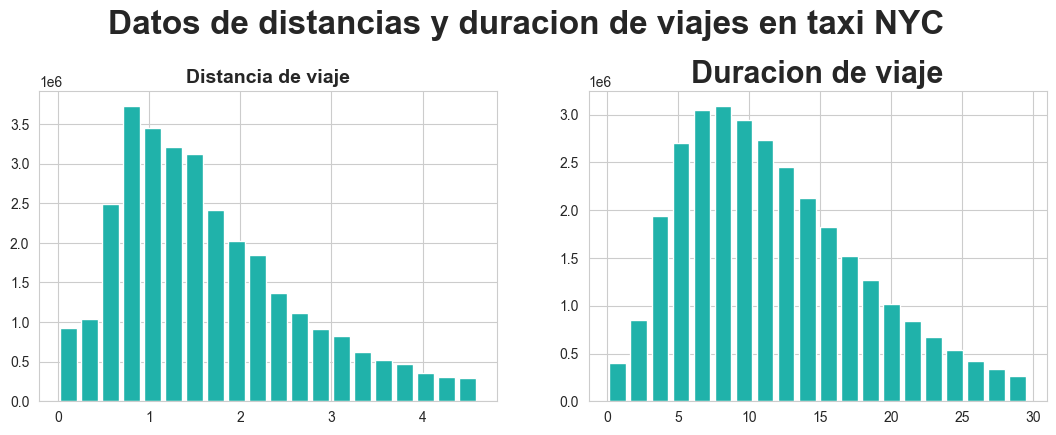

In [16]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(1,2, figsize = (13,4.5))
fig.suptitle("Datos de distancias y duracion de viajes en taxi NYC",fontsize=24, fontweight='bold')
plt.subplots_adjust(top=0.8)

ax[0].hist(taxis['trip_distance'], bins=20, rwidth=0.8, color='lightseagreen')
ax[0].set_title('Distancia de viaje',fontsize=14, fontweight='bold')

ax[1].hist(taxis['duration'], bins=20, rwidth=0.8, color='lightseagreen')
ax[1].set_title('Duracion de viaje', fontsize=22, fontweight='bold')

plt.show()